In [1]:
import pyro
from pyro.nn import PyroSample, PyroModule
from pyro.infer import SVI, Trace_ELBO, autoguide
import torch
from torch.nn.functional import softplus
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ann
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import numpy as np

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = ann.read_h5ad("/mnt/storage/thien/projectdata/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad")

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
# simulate data\n,
n_obs = 100
n_features = 20
n_factors = 5

torch.manual_seed(2024)
Z_in = torch.randn(n_obs, n_factors)
W1_in = torch.randn(n_features, n_factors)
W2_in = torch.randn(n_features, n_factors)

X1 = torch.randn(n_obs, n_features)
X2 = torch.randn(n_obs, n_features)

# create observated values from the simulated factor and weight matrix with some random noise\n,
Y1 = torch.matmul(Z_in, W1_in.t()) + 0.2 * torch.randn(n_obs, n_features)
Y2 = torch.matmul(Z_in, W2_in.t()) + 0.2 * torch.randn(n_obs, n_features)
#print(Y.shape)\n,
#print(Y)\n,


In [7]:
pca1 = PCA(n_components=20)
W1 = pca1.fit_transform(X1)

pca2 = PCA(n_components=20)
W2 = pca2.fit_transform(X2)

cca = CCA(n_components=20)
W1_aligned, W2_aligned = cca.fit_transform(W1, W2)

In [16]:
np.random.seed(42)
X1 = np.random.rand(100, 20)  # Modality 1
X2 = np.random.rand(100, 30)  # Modality 2

# Initialize shared and private components using PCA
n, k = 100, 10  # Number of samples and latent dimensions
pca1 = PCA(n_components=k)
S1_init = pca1.fit_transform(X1)

pca2 = PCA(n_components=k)
S2_init = pca2.fit_transform(X2)

# Initialize S as the average of the two PCA initializations
S = (S1_init + S2_init) / 2
U1 = X1 - S @ np.linalg.pinv(S.T @ S) @ S.T @ X1
U2 = X2 - S @ np.linalg.pinv(S.T @ S) @ S.T @ X2

# Define hyperparameters
lambda_reg = 0.1
num_iterations = 100




In [32]:
(X1 - S @ np.linalg.pinv(S.T @ S) @ S.T @ X1).shape

(100, 20)

In [25]:
U1.shape

(100, 20)

In [8]:
class FA(PyroModule):
    def __init__(self, Y1, Y2, K):
        """
        Args:
            Y: Tensor (Samples x Features)
            K: Number of Latent Factors
        """
        super().__init__()
        pyro.clear_param_store()
        
        # data
        self.Y1 = Y1
        self.Y2 = Y2
        self.K = K
        
        self.num_samples = self.Y1.shape[0]
        self.num_features1 = self.Y1.shape[1]
        self.num_features2 = self.Y2.shape[1]
        
        self.sample_plate = pyro.plate("sample", self.num_samples)
        self.feature_plate1 = pyro.plate("feature", self.num_features1)
        self.feature_plate2 = pyro.plate("feature", self.num_features2)
        self.latent_factor_plate = pyro.plate("latent factors", self.K)
        
        
    def model(self):
        """
        how to generate a matrix
        """
        with self.latent_factor_plate:
            with self.feature_plate1:
                # sample weight matrix with Normal prior distribution
                W1 = pyro.sample("W1", pyro.distributions.Normal(0., 1.))  

            with self.feature_plate1:
                # sample weight matrix with Normal prior distribution
                W2 = pyro.sample("W2", pyro.distributions.Normal(0., 1.))               
                
            with self.sample_plate:
                # sample factor matrix with Normal prior distribution
                Z = pyro.sample("Z", pyro.distributions.Normal(0., 1.))
        
        # estimate for Y
        Y1_hat = torch.matmul(Z, W1.t())
        Y2_hat = torch.matmul(Z, W2.t())
        
        with pyro.plate("feature1_", self.Y1.shape[1]), pyro.plate("sample_", self.Y1.shape[0]):
            # masking the NA values such that they are not considered in the distributions
            obs_mask = torch.ones_like(self.Y1, dtype=torch.bool)
            if data is not None:
                obs_mask = torch.logical_not(torch.isnan(self.Y1))
            with pyro.poutine.mask(mask=obs_mask):
                if data is not None:
                    # a valid value for the NAs has to be defined even though these samples will be ignored later
                    self.Y1 = torch.nan_to_num(self.Y1, nan=0) 
            
                    # sample scale parameter for each feature-sample pair with LogNormal prior (has to be positive)
                    scale = pyro.sample("scale", pyro.distributions.LogNormal(0., 1.))
                    # compare sampled estimation to the true observation Y
                    pyro.sample("obs1", pyro.distributions.Normal(Y1_hat, scale), obs=self.Y1)


        with pyro.plate("feature2_", self.Y2.shape[1]), pyro.plate("sample2_", self.Y2.shape[0]):
            # masking the NA values such that they are not considered in the distributions
            obs_mask = torch.ones_like(self.Y2, dtype=torch.bool)
            if data is not None:
                obs_mask = torch.logical_not(torch.isnan(self.Y2))
            with pyro.poutine.mask(mask=obs_mask):
                if data is not None:
                    # a valid value for the NAs has to be defined even though these samples will be ignored later
                    self.Y2 = torch.nan_to_num(self.Y2, nan=0) 
            
                    # sample scale parameter for each feature-sample pair with LogNormal prior (has to be positive)
                    scale = pyro.sample("scale2", pyro.distributions.LogNormal(0., 1.))
                    # compare sampled estimation to the true observation Y
                    pyro.sample("obs2", pyro.distributions.Normal(Y2_hat, scale), obs=self.Y2)


    def train(self):
        # set training parameters
        optimizer = pyro.optim.Adam({"lr": 0.02})
        elbo = Trace_ELBO()
        guide = autoguide.AutoDelta(self.model)
        
        # initialize stochastic variational inference
        svi = SVI(
            model = self.model,
            guide = guide,
            optim = optimizer,
            loss = elbo
        )
        
        num_iterations = 2000
        train_loss = []
        for j in range(num_iterations):
            # calculate the loss and take a gradient step
            loss = svi.step()

            train_loss.append(loss/self.Y1.shape[0])
            if j % 200 == 0:
                print("[iteration %04d] loss: %.4f" % (j + 1, loss / self.Y1.shape[0]))
        
        # Obtain maximum a posteriori estimates for W and Z
        map_estimates = guide(Y1)
        
        return train_loss, map_estimates

In [9]:
FA_model = FA(Y1, Y2,5)
losses, estimates = FA_model.train()

/home/thien/.local/lib/python3.8/site-packages/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'feature', 'sample', 'latent factors'}
  warnings.warn(


[iteration 0001] loss: 221.2648


/home/thien/.local/lib/python3.8/site-packages/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'feature', 'sample', 'latent factors'}
  warnings.warn(


[iteration 0201] loss: 23.9405
[iteration 0401] loss: 17.9655
[iteration 0601] loss: 16.7476
[iteration 0801] loss: 16.3922
[iteration 1001] loss: 16.2795
[iteration 1201] loss: 16.2441
[iteration 1401] loss: 16.2343
[iteration 1601] loss: 16.2240
[iteration 1801] loss: 16.2179


In [85]:
import pyro
import pyro.distributions as dist
import torch
import torch.nn as nn
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

class MultiViewFactorization(nn.Module):
    def __init__(self, num_samples, num_features1, num_features2, num_factors):
        super(MultiViewFactorization, self).__init__()
        self.num_samples = num_samples
        self.num_features1 = num_features1
        self.num_features2 = num_features2
        self.num_factors = num_factors
        
        # Initialize shared latent factors
        self.S = nn.Parameter(torch.randn(num_samples, num_factors))
        
        # Initialize private latent factors for each view
        self.U1 = nn.Parameter(torch.randn(num_features1, num_factors))
        self.U2 = nn.Parameter(torch.randn(num_features2, num_factors))

    def model(self, X1, X2):
        # Priors
        S_prior = dist.Normal(torch.zeros(self.num_samples, self.num_factors), torch.ones(self.num_samples, self.num_factors)).to_event(2)
        U1_prior = dist.Normal(torch.zeros(self.num_features1, self.num_factors), torch.ones(self.num_features1, self.num_factors)).to_event(2)
        U2_prior = dist.Normal(torch.zeros(self.num_features2, self.num_factors), torch.ones(self.num_features2, self.num_factors)).to_event(2)
        
        # Sample from priors
        S = pyro.sample('S', S_prior)
        U1 = pyro.sample('U1', U1_prior)
        U2 = pyro.sample('U2', U2_prior)
        
        # Likelihood
        X1_hat = torch.matmul(S, U1.T)
        X2_hat = torch.matmul(S, U2.T)
        
        with pyro.plate('data1', X1.shape[0]):
            pyro.sample('obs1', dist.Normal(X1_hat, 1.0).to_event(1), obs=X1)
        
        with pyro.plate('data2', X2.shape[0]):
            pyro.sample('obs2', dist.Normal(X2_hat, 1.0).to_event(1), obs=X2)

    def guide(self, X1, X2):
        # Variational distributions
        S_loc = pyro.param('S_loc', torch.randn(self.num_samples, self.num_factors))
        S_scale = pyro.param('S_scale', torch.ones(self.num_samples, self.num_factors), constraint=dist.constraints.positive)
        U1_loc = pyro.param('U1_loc', torch.randn(self.num_features1, self.num_factors))
        U1_scale = pyro.param('U1_scale', torch.ones(self.num_features1, self.num_factors), constraint=dist.constraints.positive)
        U2_loc = pyro.param('U2_loc', torch.randn(self.num_features2, self.num_factors))
        U2_scale = pyro.param('U2_scale', torch.ones(self.num_features2, self.num_factors), constraint=dist.constraints.positive)
        
        S_dist = dist.Normal(S_loc, S_scale).to_event(2)
        U1_dist = dist.Normal(U1_loc, U1_scale).to_event(2)
        U2_dist = dist.Normal(U2_loc, U2_scale).to_event(2)
        
        pyro.sample('S', S_dist)
        pyro.sample('U1', U1_dist)
        pyro.sample('U2', U2_dist)

# Example usage:
num_samples = 100
num_features1 = 20
num_features2 = 30
num_factors = 10
num_iterations = 5000

# Generate synthetic data
X1 = torch.randn(num_samples, num_features1)
X2 = torch.randn(num_samples, num_features2)

# Initialize the model
model = MultiViewFactorization(num_samples, num_features1, num_features2, num_factors)

# Setup the optimizer and the inference algorithm
optimizer = Adam({"lr": 0.02})
svi = SVI(model.model, model.guide, optimizer, loss=Trace_ELBO())

# Train the model
for i in range(num_iterations):
    loss = svi.step(X1, X2)
    if i % 100 == 0:
        print(f"Step {i} : loss = {loss}")

# Get the learned latent factors
S_posterior = pyro.param("S_loc").detach().numpy()
U1_posterior = pyro.param("U1_loc").detach().numpy()
U2_posterior = pyro.param("U2_loc").detach().numpy()

print("Shared components (S):\n", S_posterior)
print("\nPrivate components for view 1 (U1):\n", U1_posterior)
print("\nPrivate components for view 2 (U2):\n", U2_posterior)

Step 0 : loss = 9318.558555603027


Step 100 : loss = 8188.762435913086
Step 200 : loss = 8140.568473815918
Step 300 : loss = 8099.411827087402
Step 400 : loss = 8090.755569458008
Step 500 : loss = 8125.01838684082
Step 600 : loss = 8119.451477050781
Step 700 : loss = 8130.613334655762
Step 800 : loss = 8129.570518493652
Step 900 : loss = 8072.03630065918
Step 1000 : loss = 8095.539978027344
Step 1100 : loss = 8127.798934936523
Step 1200 : loss = 8098.893905639648
Step 1300 : loss = 8076.998802185059
Step 1400 : loss = 8065.0046310424805
Step 1500 : loss = 8054.4304122924805
Step 1600 : loss = 8096.44970703125
Step 1700 : loss = 8083.843765258789
Step 1800 : loss = 8124.302635192871
Step 1900 : loss = 8107.515960693359
Step 2000 : loss = 8127.2685546875
Step 2100 : loss = 8115.371719360352
Step 2200 : loss = 8070.581451416016
Step 2300 : loss = 8083.663627624512
Step 2400 : loss = 8093.483543395996
Step 2500 : loss = 8127.0180740356445
Step 2600 : loss = 8084.9541015625
Step 2700 : loss = 8084.7431640625
Step 2800 : loss

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Step 0 : loss = 243590.5446
Step 100 : loss = 150250.5604
Step 200 : loss = 142902.5009
Step 300 : loss = 141011.0393
Step 400 : loss = 140425.8809
Step 500 : loss = 140092.1438
Step 600 : loss = 139954.9001
Step 700 : loss = 139929.7815
Step 800 : loss = 139918.1588
Step 900 : loss = 139859.0770
Step 1000 : loss = 139876.7594
Step 1100 : loss = 139833.7688
Step 1200 : loss = 139791.3052
Step 1300 : loss = 139820.4505
Step 1400 : loss = 139841.3021
Step 1500 : loss = 139885.2786
Step 1600 : loss = 139850.6435
Step 1700 : loss = 139884.9763
Step 1800 : loss = 139837.1411
Step 1900 : loss = 139819.0336


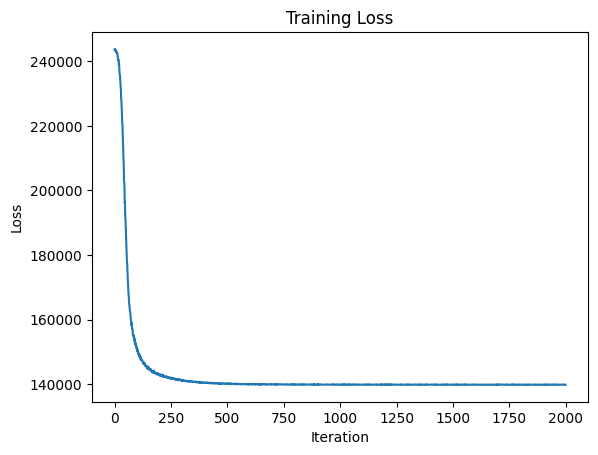

Shared components (S):
 [[-8.63709211e-01  2.09232390e-01  8.24061096e-01 -2.72854328e-01
   1.47850260e-01  2.77108520e-01  1.97326913e-01  1.29438844e-02
  -1.61517859e-01  3.34947288e-01]
 [-1.32977441e-01  6.48378730e-01  2.62418464e-02  8.96589831e-02
   3.44604552e-01  4.55751777e-01  5.83646834e-01  1.22494409e-02
  -5.76646984e-01  5.41932344e-01]
 [-3.79255891e-01 -1.97905675e-01  2.75328249e-01  2.27467835e-01
  -2.19322503e-01  2.75572807e-01  4.43844944e-01  9.24141824e-01
   1.04378068e+00  4.94581342e-01]
 [-3.76625299e-01  7.05389321e-01  4.71491396e-01  5.22026479e-01
  -2.90651888e-01 -5.63940883e-01  4.52707380e-01  2.06001431e-01
   3.10370028e-01 -1.12512540e-02]
 [-1.08770585e+00  1.43921494e-01  6.08203351e-01  8.48506629e-01
  -1.27528101e-01  6.44623786e-02 -2.56117940e-01 -1.21938539e+00
   7.23532200e-01  4.47709322e-01]
 [-1.57225585e+00  1.00532424e+00 -6.80912063e-02 -4.85539466e-01
  -1.90644279e-01  7.15210557e-01  1.89457536e-01 -1.43245652e-01
  -2.6358

In [1]:
import pyro
import pyro.distributions as dist
import torch
import torch.nn as nn
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt

class MOFA(nn.Module):
    def __init__(self, num_samples, num_features1, num_features2, num_factors):
        super(MOFA, self).__init__()
        self.num_samples = num_samples
        self.num_features1 = num_features1
        self.num_features2 = num_features2
        self.num_factors = num_factors
        
        # Initialize shared latent factors
        self.S = nn.Parameter(torch.randn(num_samples, num_factors) * 0.01)
        
        # Initialize private latent factors for each view
        self.U1 = nn.Parameter(torch.randn(num_factors, num_features1) * 0.01)
        self.U2 = nn.Parameter(torch.randn(num_factors, num_features2) * 0.01)

    def model(self, X1, X2):
        # Priors
        S_prior = dist.Normal(torch.zeros(self.num_samples, self.num_factors), torch.ones(self.num_samples, self.num_factors)).to_event(2)
        U1_prior = dist.Normal(torch.zeros(self.num_factors, self.num_features1), torch.ones(self.num_factors, self.num_features1)).to_event(2)
        U2_prior = dist.Normal(torch.zeros(self.num_factors, self.num_features2), torch.ones(self.num_factors, self.num_features2)).to_event(2)
        
        # Sample from priors
        S = pyro.sample('S', S_prior)
        U1 = pyro.sample('U1', U1_prior)
        U2 = pyro.sample('U2', U2_prior)
        
        # Likelihood
        X1_hat = torch.matmul(S, U1)
        X2_hat = torch.matmul(S, U2)
        
        with pyro.plate('data1', X1.shape[0]):
            pyro.sample('obs1', dist.Normal(X1_hat, 0.1).to_event(1), obs=X1)
        
        with pyro.plate('data2', X2.shape[0]):
            pyro.sample('obs2', dist.Normal(X2_hat, 0.1).to_event(1), obs=X2)

    def guide(self, X1, X2):
        # Variational distributions
        S_loc = pyro.param('S_loc', torch.randn(self.num_samples, self.num_factors) * 0.01)
        S_scale = pyro.param('S_scale', torch.ones(self.num_samples, self.num_factors) * 0.1, constraint=dist.constraints.positive)
        U1_loc = pyro.param('U1_loc', torch.randn(self.num_factors, self.num_features1) * 0.01)
        U1_scale = pyro.param('U1_scale', torch.ones(self.num_factors, self.num_features1) * 0.1, constraint=dist.constraints.positive)
        U2_loc = pyro.param('U2_loc', torch.randn(self.num_factors, self.num_features2) * 0.01)
        U2_scale = pyro.param('U2_scale', torch.ones(self.num_factors, self.num_features2) * 0.1, constraint=dist.constraints.positive)
        
        S_dist = dist.Normal(S_loc, S_scale).to_event(2)
        U1_dist = dist.Normal(U1_loc, U1_scale).to_event(2)
        U2_dist = dist.Normal(U2_loc, U2_scale).to_event(2)
        
        pyro.sample('S', S_dist)
        pyro.sample('U1', U1_dist)
        pyro.sample('U2', U2_dist)

# Example usage:
num_samples = 100
num_features1 = 20
num_features2 = 30
num_factors = 10
num_iterations = 2000

# Generate synthetic data
X1 = torch.randn(num_samples, num_features1)
X2 = torch.randn(num_samples, num_features2)

# Initialize the model
model = MOFA(num_samples, num_features1, num_features2, num_factors)

# Setup the optimizer and the inference algorithm
optimizer = Adam({"lr": 0.01})
svi = SVI(model.model, model.guide, optimizer, loss=Trace_ELBO())

# Train the model and log loss
losses = []
for i in range(num_iterations):
    loss = svi.step(X1, X2)
    losses.append(loss)
    if i % 100 == 0:
        print(f"Step {i} : loss = {loss:.4f}")

# Plot the loss curve
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Get the learned latent factors
S_posterior = pyro.param("S_loc").detach().numpy()
U1_posterior = pyro.param("U1_loc").detach().numpy()
U2_posterior = pyro.param("U2_loc").detach().numpy()

print("Shared components (S):\n", S_posterior)
print("\nPrivate components for view 1 (U1):\n", U1_posterior)
print("\nPrivate components for view 2 (U2):\n", U2_posterior)


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Step 0 : loss = 194540.6444
Step 100 : loss = 115043.6724
Step 200 : loss = 106874.1709
Step 300 : loss = 105968.7208
Step 400 : loss = 105607.4516
Step 500 : loss = 105537.8258
Step 600 : loss = 105463.1783
Step 700 : loss = 105392.6577
Step 800 : loss = 105364.0358
Step 900 : loss = 105286.4424
Step 1000 : loss = 105284.5232
Step 1100 : loss = 105253.5972
Step 1200 : loss = 105277.3847
Step 1300 : loss = 105260.7049
Step 1400 : loss = 105213.9714
Step 1500 : loss = 105213.0427
Step 1600 : loss = 105199.9575
Step 1700 : loss = 105192.8840
Step 1800 : loss = 105203.5610
Step 1900 : loss = 105187.3970


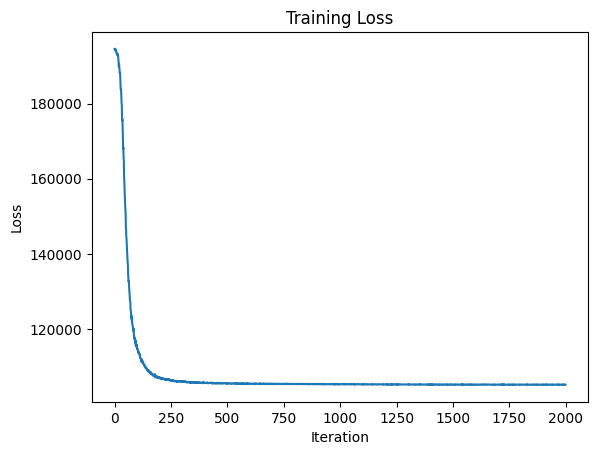

Shared components (S):
 [[ 0.80780417 -1.031694    0.12815581  0.7054087   0.0016936  -0.19106233
   0.5433078   0.10765265  0.05039915 -0.87044024]
 [-0.24079509  0.14654124  0.16089876 -0.5082666   1.1496487   0.68565655
  -0.09482611 -0.27112085 -0.30456555  0.26670495]
 [-0.04181113  0.06469231  0.10167211 -0.05991043 -0.5009462   0.05299752
  -0.08315547 -0.08625704 -0.8531008  -0.1854267 ]
 [ 0.00465224  0.6517089  -0.48309332  0.6746879  -0.0443603   0.15440361
  -0.4680775   0.00387201  0.7430932   0.4276217 ]
 [-0.29619566 -0.5433798  -0.5818675   0.0873684   0.3103447  -0.29843554
  -0.48302862  0.3985558   0.16224843  0.79655325]
 [ 1.1949021  -0.15510868 -0.03824721 -0.5351086   0.5949273  -1.0447222
  -0.37534356 -0.41294348  0.0120201  -0.4446983 ]
 [-0.21902633  0.7378738  -0.5747696   0.5311556  -0.08235669 -0.04316316
   0.31887257  0.82405555 -0.4763242  -0.61583793]
 [ 0.28357705 -0.7427344   0.11377211  0.5914798   0.7616836   0.3125154
   0.37472117 -0.48812643  0.

In [1]:
import pyro
import pyro.distributions as dist
import torch
import torch.nn as nn
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt

class MOFA(nn.Module):
    def __init__(self, num_samples, num_features1, num_features2, num_factors):
        super(MOFA, self).__init__()
        self.num_samples = num_samples
        self.num_features1 = num_features1
        self.num_features2 = num_features2
        self.num_factors = num_factors
        
        # Initialize shared latent factors
        self.S = nn.Parameter(torch.randn(num_samples, num_factors) * 0.01)
        
        # Initialize private latent factors for each view
        self.U1 = nn.Parameter(torch.randn(num_factors, num_features1) * 0.01)
        self.U2 = nn.Parameter(torch.randn(num_factors, num_features2) * 0.01)

    def model(self, X1, X2):
        # Priors
        S_prior = dist.Normal(torch.zeros(self.num_samples, self.num_factors), torch.ones(self.num_samples, self.num_factors)).to_event(2)
        U1_prior = dist.Normal(torch.zeros(self.num_factors, self.num_features1), torch.ones(self.num_factors, self.num_features1)).to_event(2)
        U2_prior = dist.Normal(torch.zeros(self.num_factors, self.num_features2), torch.ones(self.num_factors, self.num_features2)).to_event(2)
        
        # Sample from priors
        S = pyro.sample('S', S_prior)
        U1 = pyro.sample('U1', U1_prior)
        U2 = pyro.sample('U2', U2_prior)
        
        # Likelihood
        X1_hat = torch.matmul(S, U1)
        X2_hat = torch.matmul(S, U2)
        
        with pyro.plate('data1', X1.shape[0]):
            pyro.sample('obs1', dist.Normal(X1_hat, 0.1).to_event(1), obs=X1)
        
        with pyro.plate('data2', X2.shape[0]):
            pyro.sample('obs2', dist.Normal(X2_hat, 0.1).to_event(1), obs=X2)

    def guide(self, X1, X2):
        # Variational distributions
        S_loc = pyro.param('S_loc', torch.randn(self.num_samples, self.num_factors) * 0.01)
        S_scale = pyro.param('S_scale', torch.ones(self.num_samples, self.num_factors) * 0.1, constraint=dist.constraints.positive)
        U1_loc = pyro.param('U1_loc', torch.randn(self.num_factors, self.num_features1) * 0.01)
        U1_scale = pyro.param('U1_scale', torch.ones(self.num_factors, self.num_features1) * 0.1, constraint=dist.constraints.positive)
        U2_loc = pyro.param('U2_loc', torch.randn(self.num_factors, self.num_features2) * 0.01)
        U2_scale = pyro.param('U2_scale', torch.ones(self.num_factors, self.num_features2) * 0.1, constraint=dist.constraints.positive)
        
        S_dist = dist.Normal(S_loc, S_scale).to_event(2)
        U1_dist = dist.Normal(U1_loc, U1_scale).to_event(2)
        U2_dist = dist.Normal(U2_loc, U2_scale).to_event(2)
        
        pyro.sample('S', S_dist)
        pyro.sample('U1', U1_dist)
        pyro.sample('U2', U2_dist)

# Example usage:
num_samples2 = 100
num_samples = 80
num_features1 = 20
num_features2 = 30
num_factors = 10
num_iterations = 2000

# Generate synthetic data
X1 = torch.randn(num_samples2, num_features1)
X2 = torch.randn(num_samples2, num_features2)

X1_train = X1[:num_samples]
X2_train = X2[:num_samples]
X1_val = X1[num_samples:]
X2_val = X2[num_samples:]

# Initialize the model
model = MOFA(num_samples, num_features1, num_features2, num_factors)

# Setup the optimizer and the inference algorithm
optimizer = Adam({"lr": 0.01})
svi = SVI(model.model, model.guide, optimizer, loss=Trace_ELBO())

# Train the model and log loss
losses = []
for i in range(num_iterations):
    loss = svi.step(X1_train, X2_train)
    losses.append(loss)
    if i % 100 == 0:
        print(f"Step {i} : loss = {loss:.4f}")

# Plot the loss curve
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Get the learned latent factors
S_posterior = pyro.param("S_loc").detach().numpy()
U1_posterior = pyro.param("U1_loc").detach().numpy()
U2_posterior = pyro.param("U2_loc").detach().numpy()

print("Shared components (S):\n", S_posterior)
print("\nPrivate components for view 1 (U1):\n", U1_posterior)
print("\nPrivate components for view 2 (U2):\n", U2_posterior)

In [2]:
import pyro
import pyro.distributions as dist
import torch
import torch.nn as nn
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt

class MOFA(nn.Module):
    def __init__(self, training_size, num_features1, num_features2, num_factors):
        super(MOFA, self).__init__()
        self.training_size = training_size
        self.num_features1 = num_features1
        self.num_features2 = num_features2
        self.num_factors = num_factors

        self.sample_plate = pyro.plate("sample", 80)
        self.feature_plate1 = pyro.plate("feature1", num_features1)
        self.feature_plate2 = pyro.plate("feature2", num_features2)
        self.latent_factor_plate = pyro.plate("latent factors", num_factors)

    def model(self, X1, X2):
        
        num_samples = X1.shape[0]  # Update num_samples based on the current batch size
        print(f"num_samples:{self.training_size}")
        # Priors
        print(f"feature_plate1:{self.feature_plate1}")
        #print(f"feature_plate2:{self.feature_plate2.shape}")
        #print(f"sample_plate:{self.sample_plate.shape}")
        #print(f"latent_factor:{self.latent_factor_plate.shape}")
        with self.latent_factor_plate:
            with self.feature_plate1:
                U1 = pyro.sample("U1", pyro.distributions.Normal(0., 1.))
            with self.feature_plate2:
                U2 = pyro.sample("U2", pyro.distributions.Normal(0., 1.))
        
        with self.latent_factor_plate:
            with self.sample_plate:
                S = pyro.sample("S", pyro.distributions.Normal(0., 1.))
        print(f"S.shape: {S.shape}")

        #S_prior = dist.MultivariateNormal(torch.zeros(self.num_samples, self.num_factors), torch.ones(self.num_samples, self.num_factors))
        #U1_prior = dist.MultivariateNormal(torch.zeros(self.num_factors, self.num_features1), torch.ones(self.num_factors, self.num_features1))
        #U2_prior = dist.MultivariateNormal(torch.zeros(self.num_factors, self.num_features2), torch.ones(self.num_factors, self.num_features2))
        
        # Sample from priors
        #S = pyro.sample('S', S_prior)
        #print(f"S.shape: {S.shape}, S_prior.shape: {S_prior.shape}")
        #U1 = pyro.sample('U1', U1_prior)
        #U2 = pyro.sample('U2', U2_prior)
        #print(f"U1.shape: {U1.shape}, U1_prior.shape: {U1_prior.shape}")
        #print(f"U2.shape: {U2.shape}, U2_prior.shape: {U2_prior.shape}")

        # Likelihood
        X1_hat = torch.matmul(S, U1)
        X2_hat = torch.matmul(S, U2)

        # Debugging: print shapes
        print(f"X1.shape: {X1.shape}, X1_hat.shape: {X1_hat.shape}")
        print(f"X2.shape: {X2.shape}, X2_hat.shape: {X2_hat.shape}")
        
        with pyro.plate('data1', X1.shape[0]):
            pyro.sample('obs1', dist.Normal(X1_hat, 0.1).to_event(1), obs=X1)
        
        with pyro.plate('data2', X2.shape[0]):
            pyro.sample('obs2', dist.Normal(X2_hat, 0.1).to_event(1), obs=X2)

    def guide(self, X1, X2):
        num_samples = X1.shape[0]  # Update num_samples based on the current batch size

        # Variational distributions
        S_loc = pyro.param('S_loc', torch.randn(num_samples, self.num_factors) * 0.01)
        S_scale = pyro.param('S_scale', torch.ones(num_samples, self.num_factors) * 0.1, constraint=dist.constraints.positive)
        U1_loc = pyro.param('U1_loc', torch.randn(self.num_factors, self.num_features1) * 0.01)
        U1_scale = pyro.param('U1_scale', torch.ones(self.num_factors, self.num_features1) * 0.1, constraint=dist.constraints.positive)
        U2_loc = pyro.param('U2_loc', torch.randn(self.num_factors, self.num_features2) * 0.01)
        U2_scale = pyro.param('U2_scale', torch.ones(self.num_factors, self.num_features2) * 0.1, constraint=dist.constraints.positive)
        
        S_dist = dist.Normal(S_loc, S_scale)
        U1_dist = dist.Normal(U1_loc, U1_scale)
        U2_dist = dist.Normal(U2_loc, U2_scale)
        
        pyro.sample('S', S_dist)
        pyro.sample('U1', U1_dist)
        pyro.sample('U2', U2_dist)

# Example usage:
num_samples = 100
num_features1 = 20
num_features2 = 30
num_factors = 10
num_iterations = 2000

# Generate synthetic data
X1 = torch.randn(num_samples, num_features1)
X2 = torch.randn(num_samples, num_features2)

# Split data into training and validation sets
train_size = int(0.8 * num_samples)
X1_train = X1[:train_size]
X2_train = X2[:train_size]
X1_val = X1[train_size:]
X2_val = X2[train_size:]

# Initialize the model with training set size
model = MOFA(train_size, num_features1, num_features2, num_factors)

# Setup the optimizer and the inference algorithm
optimizer = Adam({"lr": 0.01})
svi = SVI(model.model, model.guide, optimizer, loss=Trace_ELBO())

# Training loop with validation loss
train_losses = []
val_losses = []
for i in range(num_iterations):
    # Training step
    train_loss = svi.step(X1_train, X2_train)
    train_losses.append(train_loss)
    
    # Validation step
    with torch.no_grad():
        val_loss = svi.evaluate_loss(X1_val, X2_val)
        val_losses.append(val_loss)
    
    # Print losses every 100 iterations
    if i % 100 == 0:
        print(f"Step {i} : train loss = {train_loss:.4f}, val loss = {val_loss:.4f}")

# Plot the training and validation loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Get the learned latent factors
S_posterior = pyro.param("S_loc").detach().numpy()
U1_posterior = pyro.param("U1_loc").detach().numpy()
U2_posterior = pyro.param("U2_loc").detach().numpy()

print("Shared components (S):\n", S_posterior)
print("\nPrivate components for view 1 (U1):\n", U1_posterior)
print("\nPrivate components for view 2 (U2):\n", U2_posterior)

ValueError: Expected parameter scale (Tensor of shape (80, 10)) of distribution Normal(loc: torch.Size([80, 10]), scale: torch.Size([80, 10])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([[-7.5153e-04,  7.9524e-03, -1.4685e-02, -1.3152e-02, -3.9582e-03,
          1.6738e-02, -6.4455e-03, -3.2577e-03,  9.6545e-03,  6.8704e-03],
        [-1.3586e-02, -7.4128e-03, -5.8446e-03,  1.6944e-03,  1.3748e-02,
          1.3543e-02,  3.7426e-03, -2.8843e-04, -1.4278e-02, -2.2496e-02],
        [ 2.3326e-03,  8.1539e-03, -8.0134e-03, -5.4847e-03, -8.9556e-03,
         -1.2854e-02,  4.0325e-03, -1.4213e-03,  2.8518e-03,  2.4497e-02],
        [-1.0701e-02,  5.0509e-03, -1.1689e-02, -6.5653e-03,  6.1368e-04,
         -5.2559e-03,  5.6707e-03,  2.0287e-02, -4.5760e-05,  1.4185e-02],
        [-8.2621e-03, -3.8960e-03,  2.9848e-03,  6.8947e-03, -2.1523e-03,
          6.1014e-03,  1.8358e-02,  2.7715e-03,  6.9866e-04,  1.1319e-03],
        [-1.1346e-02, -1.6084e-02, -3.1839e-03, -1.0494e-02,  2.0535e-02,
         -6.0157e-03, -2.5741e-03, -1.0117e-03,  6.4902e-03,  1.2664e-02],
        [ 1.7731e-02, -8.6140e-03,  1.4396e-03,  7.1180e-03, -1.6629e-02,
         -8.2936e-03, -4.2207e-03,  6.3265e-03,  4.4244e-03, -3.4423e-03],
        [-6.7216e-03,  1.1415e-02, -1.0121e-02,  6.3160e-04,  1.3912e-02,
         -1.5192e-02, -9.3821e-03,  9.4143e-03,  1.0815e-02,  4.0024e-03],
        [-3.4496e-03,  1.4532e-02,  4.9688e-03,  6.2477e-03,  2.2274e-02,
         -2.5996e-03,  4.8319e-03,  6.4336e-03,  1.4151e-03, -4.9282e-03],
        [ 1.7754e-02,  2.9791e-04, -4.5913e-03,  1.3237e-02,  1.1969e-02,
          1.9174e-05, -4.4944e-03,  3.9680e-03,  1.0064e-02, -6.5683e-03],
        [ 1.0970e-02,  6.5965e-03, -5.7665e-03,  6.1478e-03, -2.0491e-02,
         -1.9834e-02,  1.4172e-03, -1.5412e-03,  5.1450e-03,  9.3163e-03],
        [ 2.4077e-03,  3.0707e-04,  1.0332e-02, -9.8482e-03, -1.0878e-02,
         -3.6927e-03,  1.2956e-03, -2.8530e-02, -9.0709e-03,  3.4082e-03],
        [ 8.5508e-03, -1.4471e-02, -1.5811e-03, -4.4619e-03,  3.9649e-03,
         -3.6528e-03,  2.0880e-04,  5.2372e-03, -2.1261e-03, -1.1329e-03],
        [-3.3590e-03,  7.7913e-03,  1.2552e-02,  7.4881e-03, -5.1135e-03,
         -1.5935e-02, -5.8256e-03,  1.2778e-02, -1.1291e-02, -1.1482e-03],
        [-8.2249e-03,  3.7427e-04, -1.8839e-03,  1.7635e-02, -6.9923e-03,
          1.0448e-02, -5.8075e-03, -8.5498e-03,  5.0828e-04,  1.7725e-02],
        [-2.1957e-03,  4.2729e-03, -1.1852e-02,  1.3250e-02, -9.7463e-03,
         -1.9277e-03, -1.2779e-02,  4.8128e-03, -1.2756e-02, -5.5508e-03],
        [ 8.4387e-03, -4.8422e-03, -5.4002e-03,  2.0782e-02, -4.5418e-04,
          1.4072e-02, -8.1385e-04, -4.0761e-03,  1.3171e-02, -2.5769e-03],
        [ 1.2041e-02,  2.8527e-03, -1.0191e-02,  3.7495e-03, -9.0913e-04,
         -3.1521e-03,  1.2779e-02,  1.0093e-02,  6.8293e-03,  8.7822e-04],
        [ 5.8267e-03, -1.1203e-03, -6.3008e-03,  1.1607e-02,  1.3727e-02,
         -6.2960e-05, -4.2095e-03,  7.1518e-03,  9.6970e-03, -9.0469e-04],
        [ 2.5385e-02, -1.0434e-02, -6.6371e-03, -1.5617e-02,  3.6638e-03,
         -2.9455e-03,  1.4149e-02,  1.6842e-03, -8.4513e-03,  1.3182e-03],
        [ 3.4336e-03, -2.5935e-03, -9.5847e-05, -1.6104e-03,  8.2406e-03,
          1.0713e-02,  8.4046e-03, -1.1686e-02, -2.8465e-03, -2.4010e-03],
        [-4.3908e-03, -5.9525e-03,  1.3110e-02, -4.3009e-03, -2.3779e-02,
         -1.4317e-02,  8.2982e-03,  6.7208e-04,  1.0733e-02,  2.3181e-03],
        [-5.6806e-03, -5.1392e-03,  1.7206e-03, -5.8418e-03, -4.0721e-04,
         -3.2598e-03,  1.2335e-03, -7.8389e-03, -5.8061e-03, -7.3555e-03],
        [-7.5651e-03,  1.4857e-02, -1.1853e-02, -8.9061e-03, -3.3348e-03,
          5.9806e-03, -8.8577e-03, -2.2593e-03,  7.0207e-03, -7.6429e-03],
        [-2.2934e-03,  8.5164e-03, -6.7852e-05,  1.2343e-02,  3.2560e-03,
          1.3789e-03,  1.3791e-02, -1.3673e-02,  3.5757e-03, -1.3867e-02],
        [-3.1955e-03,  3.7792e-04, -1.1144e-03,  2.7308e-03,  6.0082e-03,
          1.2498e-02, -4.1755e-03,  1.1241e-02,  3.5643e-03,  1.1757e-02],
        [-1.7108e-03,  5.3539e-03,  4.0807e-03, -7.8556e-03,  2.7290e-03,
         -1.1491e-02,  2.3379e-03,  6.3675e-04, -7.2811e-03, -1.2743e-02],
        [ 1.8827e-02,  3.9007e-03, -3.4659e-03, -1.2023e-03, -1.6646e-02,
          7.8235e-03, -6.2044e-03,  1.2708e-02, -7.2266e-03,  8.0115e-03],
        [-1.2078e-02,  3.8256e-03, -9.8818e-03, -1.0222e-03, -4.1538e-03,
         -7.4491e-03, -4.9677e-03, -1.7656e-03,  2.2046e-02, -1.3693e-02],
        [-4.1303e-03,  1.1195e-03,  3.0516e-03,  5.9566e-03,  7.6008e-04,
          6.6179e-04, -3.2749e-03, -1.3036e-02,  1.2119e-02,  2.3647e-02],
        [ 9.2685e-03, -7.9307e-03,  1.2598e-03,  1.1249e-04, -5.0273e-03,
         -5.4999e-03,  1.1843e-04, -6.6101e-03, -4.9366e-03, -6.1857e-03],
        [-1.0847e-02,  1.8246e-04,  8.5435e-03, -1.8745e-02,  3.7225e-03,
          2.9656e-03, -4.0554e-03, -2.3806e-03, -1.4435e-02,  5.8389e-03],
        [ 1.4271e-02, -5.8695e-03, -1.3623e-02, -4.4005e-03, -4.2666e-03,
          1.2366e-02, -2.0262e-02,  4.6475e-03,  6.3077e-03,  6.3096e-04],
        [ 2.6741e-04,  9.7353e-03, -1.8867e-02,  7.4682e-04,  2.9357e-02,
          8.8037e-03, -1.7694e-04,  8.2489e-03, -5.8439e-03, -5.7696e-03],
        [ 1.5627e-02, -1.1450e-02, -1.0699e-02, -1.4618e-02,  4.5718e-03,
         -1.2111e-02, -2.7010e-04, -1.8524e-03,  1.0737e-02, -1.6932e-02],
        [ 1.9749e-02, -2.0097e-03,  4.3176e-03, -1.4114e-03,  7.9292e-03,
         -1.5775e-03,  7.3114e-03,  1.4757e-02, -1.2388e-02, -1.0032e-02],
        [-6.0577e-03,  1.2872e-03,  1.3564e-02,  1.7161e-02, -6.4677e-03,
          6.7018e-04,  9.5148e-03,  7.5262e-03, -1.0491e-02,  3.2108e-03],
        [ 1.2323e-02,  7.0607e-03,  1.5955e-02,  1.0396e-02,  2.6891e-02,
         -4.3061e-03,  1.8663e-02, -1.1638e-02, -5.6975e-03, -1.1104e-02],
        [-4.8622e-03,  9.0869e-03,  6.7971e-03,  4.0745e-04,  5.4255e-03,
          1.1000e-02, -6.6192e-03, -1.5510e-02,  6.5514e-03,  5.2316e-03],
        [ 4.2762e-03,  4.2065e-03,  3.7815e-03,  1.0249e-02,  2.6729e-03,
          6.1434e-03,  3.9737e-03,  2.3658e-03, -3.8080e-04,  6.6256e-03],
        [-1.1348e-02,  4.9032e-03,  1.9817e-02,  1.0543e-02,  1.2199e-02,
         -1.4889e-03,  7.0234e-03, -1.9309e-02,  2.1882e-02,  3.8728e-03],
        [ 8.2087e-04,  2.2324e-03, -1.0186e-02, -7.4697e-03, -1.0449e-02,
          2.9370e-03, -5.2499e-03,  1.9963e-02,  2.7734e-03, -1.0674e-02],
        [-8.0272e-03,  2.4320e-03,  9.4181e-03,  9.1364e-03,  1.5638e-02,
          1.5361e-02, -4.3510e-03, -7.8266e-03, -1.2334e-02,  5.5784e-04],
        [ 3.1121e-03, -6.3534e-03, -2.1198e-03,  1.0786e-02, -2.0840e-02,
         -6.8292e-03,  8.2246e-03,  2.1589e-03,  5.3473e-03, -2.7095e-03],
        [ 6.8180e-03,  2.8267e-04, -2.2155e-03,  1.2026e-02,  8.1462e-03,
         -5.8504e-03,  8.1413e-04, -1.6989e-02,  1.9482e-02, -3.3203e-03],
        [ 6.1740e-03,  2.3037e-02, -4.8667e-03, -1.2005e-02,  1.5399e-02,
          1.4741e-02,  3.2025e-02,  3.8010e-03, -3.8992e-03, -2.7249e-03],
        [ 1.6992e-03,  2.9624e-03, -1.5350e-03, -1.0309e-02, -2.2903e-03,
          2.3059e-02, -1.0517e-02, -7.7349e-03,  1.5390e-02,  1.1037e-02],
        [-5.8958e-03,  1.0947e-02, -1.0466e-02, -3.7938e-03,  2.9388e-03,
          7.0918e-03, -2.9881e-03, -7.5696e-03,  7.0300e-03,  3.0482e-03],
        [ 6.2233e-03,  2.1161e-02, -1.5892e-03, -5.5638e-03,  1.1282e-02,
          1.4085e-02,  1.2419e-02,  6.7188e-03,  8.2635e-03, -1.0730e-02],
        [ 2.5613e-03, -1.9970e-02, -1.1482e-02,  1.2574e-03, -7.7474e-03,
         -5.4426e-03, -1.5943e-02, -2.0498e-03,  1.7012e-02, -3.8146e-03],
        [ 1.3428e-02, -7.1400e-04,  6.3381e-03,  1.7226e-03,  1.8169e-02,
         -2.4201e-03,  1.8841e-04, -1.2842e-02, -5.8653e-03, -1.1444e-02],
        [ 4.0000e-03, -5.7893e-03,  1.1582e-02,  2.1396e-02, -8.4091e-03,
         -4.3364e-04, -9.9068e-03, -1.6680e-02,  1.9187e-04, -4.9917e-04],
        [-9.2750e-03, -2.1826e-02,  1.0034e-02, -1.1148e-02,  2.4690e-03,
         -5.2144e-03,  1.3267e-02, -3.9656e-04, -6.6513e-03, -1.4038e-03],
        [-1.1138e-02, -6.9663e-03,  2.9802e-03, -2.0679e-03, -8.4436e-03,
         -1.0897e-02, -7.7153e-03, -1.1377e-02,  1.2748e-02, -4.2077e-03],
        [ 6.8715e-03,  4.4531e-03, -3.7178e-03,  1.6703e-02, -5.5730e-04,
          1.1943e-02, -3.6138e-03,  2.8857e-03, -3.1007e-03, -2.7192e-03],
        [-1.4003e-02,  6.5354e-03, -9.4000e-03, -2.3961e-03, -1.1145e-02,
         -9.0588e-03,  5.3138e-03,  7.6147e-04,  3.7615e-03, -9.0860e-03],
        [-1.5645e-03, -1.2309e-02, -1.5208e-02,  1.1788e-02, -7.7248e-03,
         -8.4370e-03, -1.4711e-02,  8.4379e-04,  9.1744e-03, -5.2982e-03],
        [ 1.3623e-02,  1.3582e-03, -5.0128e-03, -1.6884e-02, -1.5972e-02,
         -7.6543e-03, -6.1071e-04, -9.5613e-03,  2.6569e-03,  9.4575e-04],
        [-2.4821e-02,  2.2087e-02,  1.2115e-02, -1.6833e-02,  7.0368e-03,
          1.0299e-02, -5.1292e-03, -2.0249e-02, -3.9157e-03,  6.2448e-03],
        [ 8.3537e-03, -1.9340e-02, -9.4220e-03,  8.5992e-04, -1.7199e-02,
          1.1199e-03,  2.0841e-02, -7.7692e-03,  8.5107e-03, -1.0879e-02],
        [-6.0178e-03,  5.8497e-03,  9.9066e-03,  6.9418e-03, -2.4247e-02,
         -2.0917e-03,  2.7834e-03,  3.4118e-03,  3.9291e-03,  4.2381e-03],
        [-3.4005e-03,  8.2251e-03,  1.8374e-02, -7.5742e-03,  7.8081e-03,
          1.1150e-02, -7.0568e-03, -6.4516e-03,  2.5265e-03,  1.5206e-03],
        [ 1.7182e-02, -1.0089e-02,  1.2728e-02,  2.9719e-03,  7.7078e-03,
         -2.1111e-03, -6.9720e-04,  1.9097e-04,  2.0571e-02, -1.7922e-02],
        [-3.7878e-03, -3.1196e-03, -4.1539e-03, -4.8482e-06, -1.4059e-02,
         -4.0209e-03,  1.5230e-03, -1.6368e-03, -3.2742e-03, -2.1107e-02],
        [ 8.1295e-03,  3.5142e-03,  9.3408e-03, -1.7650e-02, -7.2968e-04,
         -8.4382e-03, -7.4653e-03, -1.9500e-03,  3.6779e-04, -1.3628e-02],
        [ 1.0686e-02, -2.2491e-03,  1.1046e-03, -9.0794e-03,  1.1269e-02,
         -3.4036e-03, -1.0253e-02, -2.1045e-03, -2.2379e-02, -5.1032e-03],
        [ 5.5479e-03,  5.7516e-03,  2.8151e-03,  2.2742e-03, -1.4005e-02,
         -2.9803e-02,  7.1251e-03,  1.2066e-02,  1.5542e-02,  6.3944e-03],
        [ 5.7557e-03,  1.9251e-02,  8.5558e-03, -1.1652e-02,  1.5201e-03,
         -1.0179e-03,  9.2710e-04,  1.5773e-02,  5.7112e-04,  2.1389e-02],
        [ 1.6267e-02, -3.1894e-04, -7.7991e-03, -8.0482e-04,  1.6689e-02,
          1.2120e-02,  1.3700e-02, -4.8675e-04,  8.1216e-04,  3.6707e-03],
        [-3.6798e-03,  2.4795e-03, -9.2944e-04,  1.2178e-02,  7.8178e-03,
         -1.0932e-03,  1.4186e-02, -2.4218e-02,  3.2827e-03, -8.7256e-03],
        [-2.0320e-02, -4.8111e-03,  1.2077e-02, -7.6237e-03, -1.1996e-03,
          7.3698e-03,  1.9692e-02,  2.8941e-03,  4.3012e-03,  4.5482e-03],
        [-1.4000e-03,  1.0927e-02, -2.4640e-03, -1.3621e-02,  4.5426e-03,
          1.0077e-03,  7.6007e-03, -1.6237e-02,  1.5141e-02,  1.5154e-05],
        [-9.8310e-03, -6.2923e-03,  9.8289e-04, -1.2078e-02, -1.5533e-02,
          1.0501e-02,  2.1083e-02,  2.2046e-03, -2.2660e-02,  4.6123e-03],
        [-3.6071e-04,  3.7798e-03,  1.0488e-02, -2.3331e-02,  2.8663e-02,
         -6.9810e-03, -9.8968e-04,  4.0560e-03, -3.4910e-03, -5.6242e-03],
        [ 9.6888e-04, -2.4741e-04, -5.9693e-03,  1.7461e-03,  1.6628e-02,
         -6.9183e-04, -7.8596e-03, -9.7188e-04,  4.1082e-03,  1.3484e-03],
        [ 4.5669e-03,  1.6390e-03,  4.5063e-03, -5.1880e-03, -6.1829e-03,
          2.8150e-03,  1.8163e-02, -1.6840e-02,  7.3458e-03, -5.0153e-03],
        [-6.7536e-03, -9.1275e-03,  1.2241e-02, -2.6694e-03,  1.6033e-02,
         -4.8544e-03,  9.1626e-03, -7.4827e-03, -1.0938e-02,  1.0980e-02],
        [-4.6039e-03, -9.0833e-03, -1.2433e-02, -1.2233e-02, -4.4516e-03,
         -8.9392e-03,  9.5747e-03,  3.0742e-03, -3.7917e-03,  1.2057e-02],
        [ 6.4859e-03, -6.7626e-03, -5.7108e-04, -1.3519e-02, -2.2118e-03,
          5.8469e-03, -1.7568e-02, -1.4173e-02, -2.3023e-02, -1.6646e-02],
        [-2.3694e-02, -1.4996e-02, -2.8476e-02,  2.7654e-03, -4.5267e-03,
         -4.7985e-04,  7.9536e-03,  5.6022e-03,  5.2235e-03, -1.6406e-02]],
       requires_grad=True)
Trace Shapes:      
 Param Sites:      
        S_loc 80 10
      S_scale 80 10
       U1_loc 10 20
     U1_scale 10 20
       U2_loc 10 30
     U2_scale 10 30
Sample Sites:      